In [55]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
tqdm.pandas()

# Simulations if considerin the genome devided into chromosomes
# thus the window of consecutive hits has to be within a chromose

#https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37
df_chr_len = pd.read_csv('Chromosome Size.csv', thousands=',',index_col=0)
dict_chr_lenght_cumsum = df_chr_len.cumsum()['Length'].to_dict()
dict_chr_lenght_cumsum['0']=0


list_chr_lenght = df_chr_len.Length.values
genome_lenght = np.sum(list_chr_lenght) #2980 Mb
list_chr_end = np.cumsum(list_chr_lenght)
list_chr_start = list_chr_end-list_chr_lenght

# from Sakornsakolpat 2019. Genetic landscape of chronic obstructive pulmonary disease...
# supp. table 10
df_hits_all = pd.read_csv('COPD_all_hits.csv')
# add from Hobbs rs2047409 4:106137033, TET2
df_hits_all = pd.concat([df_hits_all,pd.DataFrame([[4,106137033,'rs2047409']],columns=df_hits_all.columns)],axis=0)
df_hits_all = df_hits_all.sort_values(['Chr','Pos'])
n_copd_loci = df_hits_all.shape[0]
def find_closest_group_distance(lst, k):
    # Calculate the distances for each group of k consecutive integers
    distances = np.array([lst[i+k-1] - lst[i] for i in range(len(lst) - k+1)])
    min_distance = np.min(distances,axis=0)
    return min_distance

def plot_simulation(hits,k,region_lenght):
    # NB hits and region_lenght have to be on the same scale Mb or bases
    hits = np.sort(hits)
    min_distance = find_closest_group_distance(hits,k)
    print('Min Distance Found',min_distance/10**6)

    plt.figure(figsize=[15,3])

    plt.plot(hits,np.ones(len(hits)),marker='|',linestyle='',markersize=10)    
    # get hits within region_lenght distance
    distances = np.array([(hits[i],hits[i+k-1]) for i in range(len(hits) - k+1) if hits[i+k-1] - hits[i] <region_lenght])
    # remove across chromosomes
    distances = [(x,y) for (x,y) in distances if not np.any([(y> chr_break) and (x<chr_break) for chr_break in list_chr_end])]

    for j,(start,end) in enumerate(distances):
        #print(hits[i],hits[i+k-1],hits[i+k-1]-hits[i])
        plt.plot([start,end],[1+.002*(j+1),1+.002*(j+1)],linestyle='-',c='r',label='Subsequent hits' if j==0 else '')
        plt.ylim([.998,1+.002*(j+2)])
    [plt.axvline(x,c='r',linestyle='--',linewidth=1,alpha=.6) for x in list_chr_start[1:]]
    plt.axhline(1,c='black',linewidth=1,alpha=.3)
    plt.xlim([0,genome_lenght])
    plt.xlabel('Chromosomes')
    plt.xticks([(list_chr_start[i]+list_chr_end[i])/2 for i in range(len(list_chr_start))],labels=df_chr_len.index)
    plt.yticks([1],['GWAS hits'])
    plt.legend()
    plt.title('%i Subsequent GWAS hits out of %i loci \nwithin %s MB'%(k,len(hits),f"{region_lenght/10**6:.2f}"))
    
def get_simulation_genome(n_hits_region,n_hits,region_lenght,genome_lenght,plot=False):
    # Simulate hits and count number of region not considering chromosome break
    # generate random 
    hits = np.random.randint(0,genome_lenght,size=n_hits)
    hits = np.sort(hits)
    result_simulation =False
    for start,end in zip(*[list_chr_start,list_chr_end]):
        # check in each chromosome how many times you have n_hits_region in a region of lenght within_region 
        hits_in_chr = hits[(hits>=start) & (hits<end)]
        if len(hits_in_chr)<n_hits_region:
            continue
        min_distance = find_closest_group_distance(hits_in_chr,n_hits_region)
        if min_distance <=region_lenght:
            result_simulation= True
            break
    if plot: plot_simulation(hits,n_hits_region,region_lenght)
    return result_simulation


def get_simulation_in_chr(n_hits_region,chr_hits,region_lenght,chr_lenght):
    # Simulate hits and count number of region not considering chromosome break
    # generate random 
    hits = np.random.randint(0,chr_lenght,size=chr_hits)
    hits = np.sort(hits)
    
    min_distance = find_closest_group_distance(hits,n_hits_region)
    if min_distance <=region_lenght:
        return True
    else:
        return False

In [52]:
70*10**6/10**6

70.0

### Probabilities in Chromosome 4

In [3]:
np.mean([get_simulation_genome(n_hits_region=4,n_hits=22,region_lenght=55*10**6,genome_lenght=genome_lenght) for x in range(100000)])

0.0751

In [4]:
np.mean([get_simulation_genome(n_hits_region=5,n_hits=83,region_lenght=70*10**6,genome_lenght=genome_lenght) for x in range(10000)])

0.986

### All Chromosomes

For each possible subsequent number of k hits (k=1,2,3…) in each chromosome, we tested for the statistical significance (100,000 simulations) for k hits, out of the 83 COPD GWAS signals, to be present within their genome region length (region_length). In each simulation we sampled 83 loci at random across the genome and computed the number of regions with at least k hits within the region_length. 

Text(0.5, 0.98, '')

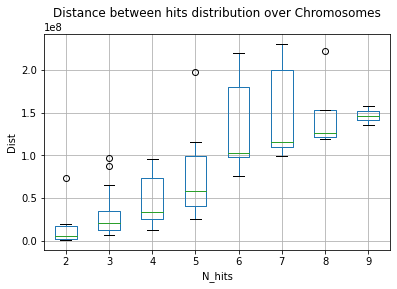

In [5]:
df_hits_all_dist = df_hits_all.groupby('Chr').apply(lambda x: [(x.Chr.iloc[0],i,find_closest_group_distance(x.Pos.values,i)) for i in range(2,len(x)+1)])
df_hits_all_dist = pd.DataFrame(itertools.chain.from_iterable(df_hits_all_dist),columns=["Chr","N_hits","Dist"])

dict_chr_lenght = {i+1:v for i,v in enumerate(list_chr_lenght)}
dict_chr_n_hits = df_hits_all_dist.groupby('Chr').N_hits.max().to_dict()

n_total_hits = df_hits_all.shape[0]
genome_length_b = sum(list_chr_lenght)
    


ax = df_hits_all_dist.boxplot('Dist',by='N_hits')
#tmp = df_hits_all_dist.query('Chr==5').copy()
#tmp.N_hits = tmp.N_hits -1
#tmp.plot(x='N_hits',y='Dist',ax=ax,linestyle='',marker='X',c='r',label='Ch5')
plt.ylabel('Dist')
ax.set_title('Distance between hits distribution over Chromosomes')
plt.suptitle('')

### Plot COPD GWAS hits and a random simulation 

Min Distance Found 24.939625


[]

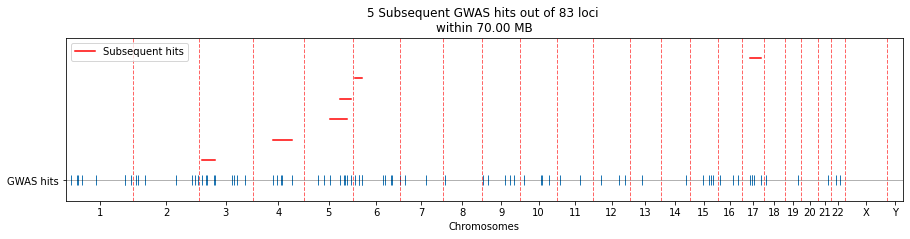

In [58]:
# Plot COPD GWAS hits 
plot_simulation(df_hits_all.Pos + [dict_chr_lenght_cumsum[str(x-1)] for x in df_hits_all.Chr],5,70*10**6)
plt.plot()

Min Distance Found 6.223433


True

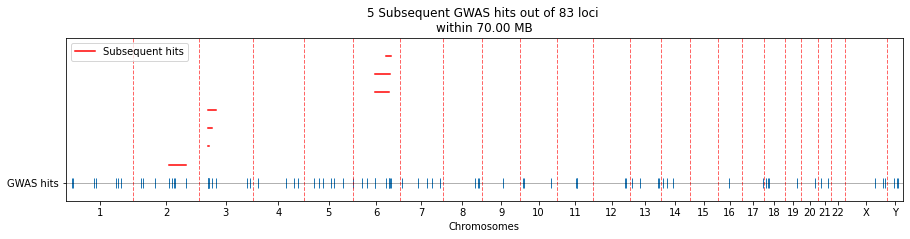

In [57]:
# Plot a GWAS simulation 
get_simulation_genome(5,n_copd_loci,70*10**6,genome_lenght,plot=True)

#### Get Pvalues

In [99]:
tot_hits=df_hits_all.shape[0]

def get_simulation_genome_fast(hits,k,region_lenght):
    # generate random 
    for start,end in zip(*[list_chr_start,list_chr_end]):
        # check in each chromosome how many times you have k in a region of lenght within_region 
        hits_in_chr = hits[(hits>=start) & (hits<end)]
        if len(hits_in_chr)<k:
            continue
        min_distance = find_closest_group_distance(hits_in_chr,k)
        if min_distance <=region_lenght:
            return True
    return False


def get_simulation_in_chr_fast(hits,k,region_lenght):
    ''' Hits has all the random sample'''
    min_distance = find_closest_group_distance(hits,k)
    return np.mean(min_distance <=region_lenght)
    
    
def n_regions_hits(hits,k,region_lenght):
    sum_distances = 0
    regions = []
    for chrom,(start,end) in enumerate(zip(*[list_chr_start,list_chr_end])):
        # check in each chromosome how many times you have n_hits_region in a region of lenght within_region 
        hits_in_chr = hits[(hits>=start) & (hits<end)]
        if len(hits_in_chr)<k:
            continue
        distances = np.array([hits_in_chr[i+k-1] - hits_in_chr[i] for i in range(len(hits_in_chr) - k+1)])
        sum_distances +=sum(distances<=region_lenght)
        idx = np.where(distances<=region_lenght)[0]
        for i in idx:
            regions.append([chrom,list(hits_in_chr[i:i+k])])
    return sum_distances,regions 
    
def get_sim_n_region(k,region_lenght,n_copd_hits):
    simulations_chr = get_simulation_in_chr_fast(random_hits,k,region_lenght)
    simulations_genome = np.apply_along_axis(lambda x: get_simulation_genome_fast(x,k,region_lenght),axis=0,arr=random_hits)    
    random_n_regions = np.apply_along_axis(lambda x: n_regions_hits(x,k,region_lenght),axis=0,arr=random_hits)    
    return [np.mean(simulations_chr),np.mean(simulations_genome),np.mean(random_n_regions>=n_copd_hits)] 


df_hits_all['incremental_position'] = df_hits_all.Pos.values + [dict_chr_lenght_cumsum[str(x-1)] for x in df_hits_all.Chr]
dict_hit_pos_rsid = df_hits_all.set_index('incremental_position').Rs_ID.to_dict()
copd_hits =df_hits_all['incremental_position'].values
df_hits_all_dist['copd_n_regions'] = df_hits_all_dist.apply(lambda x: n_regions_hits(copd_hits,int(x.N_hits),x.Dist),axis=1)
df_hits_all_dist['copd_regions'] = df_hits_all_dist['copd_n_regions'].map(lambda x: x[1])
df_hits_all_dist['copd_n_regions'] = df_hits_all_dist['copd_n_regions'].map(lambda x: x[0])
# generate 1000 random patients
random_hits = np.random.randint(0,genome_lenght,size=[tot_hits,10000])
random_hits.sort(axis=0)


In [53]:
# Compute Pvalue
df_hits_all_dist[['pvalue_in_chr','pvalue_genome','pvalue_genome_multiple_region',]] = list(df_hits_all_dist.progress_apply(lambda x: get_sim_n_region(int(x.N_hits),x.Dist,x.copd_n_regions),axis=1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [05:42<00:00,  5.52s/it]


In [49]:
df_hits_all_dist.sort_values('pvalue_genome_multiple_region').to_csv('Results.csv',index=False)#head(30)

In [77]:
df_hits_all_dist.sort_values('pvalue_genome_multiple_region').query('Chr==4')

,Chr,N_hits,Dist,copd_n_regions,pvalue_in_chr,pvalue_genome,pvalue_genome_multiple_region
23,4,4,31145690,6,0.9702,0.9427,0.1668
22,4,3,16935235,8,0.9970,0.9953,0.2108
24,4,5,69815735,6,0.9992,0.9874,0.4940
21,4,2,682020,1,0.7767,0.7759,0.7759


In [95]:
import pandas as pd
df_hits_all_dist = pd.read_csv('Results.csv')
df_hits_all_dist.copd_regions = df_hits_all_dist.copd_regions.apply(eval)

In [111]:
df_top_hits = pd.DataFrame(df_hits_all_dist.iloc[0]['copd_regions'], columns = ['Chr','hits'])
df_top_hits['subsequent_rs_id'] = df_top_hits.hits.apply(lambda x: list(map(dict_hit_pos_rsid.get,x)))
df_top_hits.drop('hits',axis=1).to_csv('Regions_3_hits.csv',index=False)


Min Distance Found 7.088604


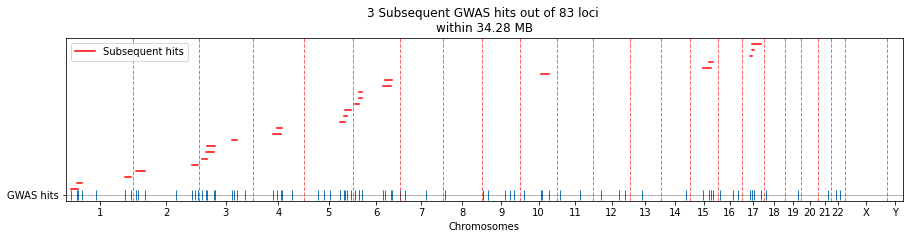

In [61]:
# Plot COPD GWAS hits 
plot_simulation(df_hits_all.Pos + [dict_chr_lenght_cumsum[str(x-1)] for x in df_hits_all.Chr],3,34275487)

Min Distance Found 7.367971


True

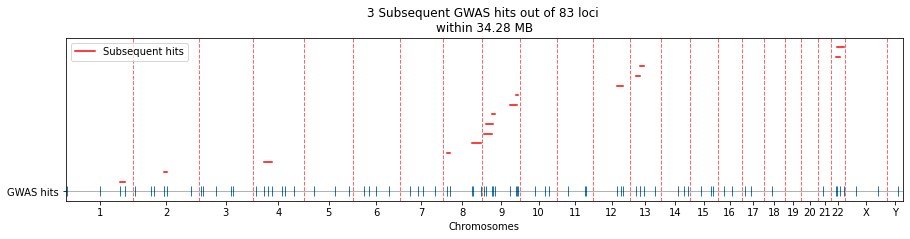

In [59]:
# visualize a simulation to find 3 hits within 34MB
get_simulation_genome(n_hits_region=3,n_hits=83,region_lenght=34275487,genome_lenght=genome_lenght,plot=True)